# 🔥 SAM 3 Training Lab — Fine-tuning Segment Anything 3
## Learn to Fine-tune SAM 3 on Custom Food Data (FoodSeg103)

---

## 📚 Table of Contents

| Lab | Topic | Difficulty | What You'll Learn |
|-----|-------|------------|-------------------|
| **Lab 5** | Training Foundations | ⭐⭐ | Prepare data, build DataLoader, understand fine-tuning |
| **Lab 6** | Fine-tune with LoRA | ⭐⭐⭐ | Parameter-efficient fine-tuning (train <1% of params) |
| **Lab 7** | Evaluation & Comparison | ⭐⭐⭐ | Measure improvements, compare before vs after |
| **Lab 8** | Advanced Techniques | ⭐⭐⭐⭐ | Data augmentation, LR scheduling, multi-prompt training |

---

## 🤔 Why Fine-tune SAM 3?

SAM 3 is a **general-purpose** segmentation model. It works on many objects,
but it may not be perfect for **your specific domain** (e.g., Thai food,
medical images, satellite imagery).

### Before vs After Fine-tuning
```
General SAM 3:                    Fine-tuned SAM 3:
┌──────────────┐                  ┌──────────────┐
│  🍳 egg      │  IoU = 0.65     │  🍳 egg      │  IoU = 0.85  ✅
│  🍚 rice     │  IoU = 0.55     │  🍚 rice     │  IoU = 0.78  ✅
│  🥬 lettuce  │  IoU = 0.40     │  🥬 lettuce  │  IoU = 0.72  ✅
└──────────────┘                  └──────────────┘
```

### Fine-tuning Strategies

| Strategy | Trainable Params | Speed | When to Use |
|----------|-----------------|-------|-------------|
| **Full fine-tune** | 100% (~848M) | 🐌 Slow | Large dataset, lots of GPU |
| **Freeze encoder** | ~30% | 🚶 Medium | Medium dataset |
| **LoRA** | <1% (~2-5M) | 🚀 Fast | Small dataset, limited GPU |
| **Prompt tuning** | <0.1% | ⚡ Fastest | Very small dataset |

> 💡 **We'll use LoRA** — it's fast, memory-efficient, and works great
> even with small datasets!

---
## 📋 Prerequisites

Make sure you've completed **Labs 1–4** (Basic Lab) before starting.
You should understand:
- ✅ How SAM 3 processes images and text prompts
- ✅ The 3-step pipeline: preprocess → inference → postprocess
- ✅ IoU (Intersection over Union) evaluation metric
- ✅ Point and box prompts for the Tracker model

---
# 🟢 Lab 5: Training Foundations

### 🎯 Learning Objectives
By the end of this lab, you will:
1. Understand **what gets trained** in SAM 3 fine-tuning
2. Prepare training data with a custom **Dataset** and **DataLoader**
3. Create proper **ground truth masks** for training
4. Understand the **loss function** for segmentation

In [1]:
# ============================================================
# Step 5.2: Import libraries & setup (carry over from basic lab)
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image as PILImage
from datasets import load_dataset
from transformers import Sam3Processor, Sam3Model
from scipy import ndimage
import random
import time
from collections import defaultdict

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🖥️  Device: cuda
   GPU: NVIDIA GeForce RTX 5090
   VRAM: 34.2 GB


In [2]:
# ============================================================
# Step 5.3: Load model and dataset
# ============================================================
from huggingface_hub import login
login(token='token')  # <-- Replace with your HF token


In [3]:
print("⏳ Loading SAM 3...")
processor = Sam3Processor.from_pretrained("facebook/sam3")
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
print("✅ SAM 3 loaded!")


⏳ Loading SAM 3...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

✅ SAM 3 loaded!


In [4]:

print("⏳ Loading FoodSeg103...")
ds = load_dataset("EduardoPacheco/FoodSeg103", split="train")
ds_val = load_dataset("EduardoPacheco/FoodSeg103", split="validation")
print(f"✅ Dataset loaded! Train: {len(ds)}, Val: {len(ds_val)}")

⏳ Loading FoodSeg103...
✅ Dataset loaded! Train: 4983, Val: 2135


In [5]:
# ============================================================
# Step 5.4: FoodSeg103 label mapping (same as basic lab)
# ============================================================
FOODSEG103_LABELS = {
    0: "background", 1: "candy", 2: "egg tart", 3: "french fries", 4: "chocolate",
    5: "biscuit", 6: "popcorn", 7: "pudding", 8: "ice cream", 9: "cheese butter",
    10: "cake", 11: "wine", 12: "milkshake", 13: "coffee", 14: "juice",
    15: "milk", 16: "tea", 17: "almond", 18: "red beans", 19: "cashew",
    20: "dried cranberries", 21: "soy", 22: "walnut", 23: "peanut", 24: "egg",
    25: "apple", 26: "date", 27: "apricot", 28: "avocado", 29: "banana",
    30: "strawberry", 31: "cherry", 32: "blueberry", 33: "raspberry", 34: "mango",
    35: "olives", 36: "peach", 37: "lemon", 38: "pear", 39: "fig",
    40: "pineapple", 41: "grape", 42: "kiwi", 43: "melon", 44: "orange",
    45: "watermelon", 46: "steak", 47: "pork", 48: "chicken duck", 49: "sausage",
    50: "fried meat", 51: "lamb", 52: "sauce", 53: "crab", 54: "fish",
    55: "shellfish", 56: "shrimp", 57: "squid", 58: "bread", 59: "corn",
    60: "dumpling", 61: "hamburger", 62: "pizza", 63: "hanamaki baozi",
    64: "wonton", 65: "pasta", 66: "rice", 67: "noodles", 68: "soup",
    69: "cake", 70: "hotdog", 71: "spring roll", 72: "tofu", 73: "asparagus",
    74: "broccoli", 75: "Brussels sprout", 76: "cabbage", 77: "carrot",
    78: "celery", 79: "corn", 80: "cucumber", 81: "eggplant",
    82: "garlic", 83: "ginger", 84: "lettuce", 85: "mushroom",
    86: "onion", 87: "pepper", 88: "potato", 89: "pumpkin",
    90: "sweet potato", 91: "tomato", 92: "bean sprouts", 93: "green beans",
    94: "spinach", 95: "bell pepper", 96: "white radish", 97: "kidney beans",
    98: "mixed vegetables", 99: "crispy chicken", 100: "chicken wings",
    101: "french beans", 102: "other ingredients", 103: "salad"
}
LABEL_TO_ID = {name: cid for cid, name in FOODSEG103_LABELS.items()}

# Focus classes for training (common foods with good coverage)
TRAIN_CLASSES = ["egg", "rice", "bread", "tomato", "lettuce", "chicken duck",
                 "broccoli", "carrot", "potato", "mushroom"]

print(f"✅ Labels loaded. Training on {len(TRAIN_CLASSES)} focus classes:")
for cls in TRAIN_CLASSES:
    print(f"   • {cls} (ID: {LABEL_TO_ID[cls]})")

✅ Labels loaded. Training on 10 focus classes:
   • egg (ID: 24)
   • rice (ID: 66)
   • bread (ID: 58)
   • tomato (ID: 91)
   • lettuce (ID: 84)
   • chicken duck (ID: 48)
   • broccoli (ID: 74)
   • carrot (ID: 77)
   • potato (ID: 88)
   • mushroom (ID: 85)


### 💡 Key Concept: What is a Custom PyTorch Dataset?

PyTorch needs data in a specific format. A **Dataset** class wraps your data
and returns one sample at a time. A **DataLoader** batches samples together.

```
FoodSeg103          Custom Dataset         DataLoader
┌──────────┐       ┌──────────────┐       ┌──────────┐
│ image    │       │ pixel_values │       │ batch of │
│ label    │  →    │ input_ids    │  →    │ 4 samples│
│ classes  │       │ gt_mask      │       │ shuffled │
└──────────┘       └──────────────┘       └──────────┘
```

In [6]:
# ============================================================
# Step 5.5: Build Custom Dataset for Text-Prompted Training
# ============================================================

class FoodSegTextDataset(Dataset):
    """
    Custom dataset for fine-tuning SAM 3 with text prompts.

    For each sample, we:
    1. Pick an image containing a target food class
    2. Use the food name as the text prompt
    3. Extract the ground truth binary mask for that class
    """

    def __init__(self, hf_dataset, processor, target_classes, max_samples=500):
        """
        Args:
            hf_dataset: HuggingFace FoodSeg103 dataset split
            processor: Sam3Processor for preprocessing
            target_classes: list of food class names to train on
            max_samples: max samples to include (for faster training)
        """
        self.processor = processor
        self.samples = []  # Will hold (image_idx, class_name, class_id) tuples

        print(f"⏳ Building dataset (scanning for target classes)...")

        # Find images containing our target classes
        for idx in range(len(hf_dataset)):
            sample = hf_dataset[idx]
            image_classes = sample['classes_on_image']

            for cls_name in target_classes:
                cls_id = LABEL_TO_ID.get(cls_name)
                if cls_id is not None and cls_id in image_classes:
                    self.samples.append((idx, cls_name, cls_id))

            if len(self.samples) >= max_samples:
                break

        # Shuffle and trim
        random.shuffle(self.samples)
        self.samples = self.samples[:max_samples]
        self.hf_dataset = hf_dataset

        # Print class distribution
        class_counts = defaultdict(int)
        for _, cls_name, _ in self.samples:
            class_counts[cls_name] += 1

        print(f"✅ Dataset built: {len(self.samples)} samples")
        print("   Class distribution:")
        for cls, count in sorted(class_counts.items(), key=lambda x: -x[1]):
            print(f"     {cls:>15s}: {count:>4d} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_idx, cls_name, cls_id = self.samples[idx]
        sample = self.hf_dataset[img_idx]

        # Get image and ground truth mask
        image = sample['image'].convert("RGB")
        label_array = np.array(sample['label'])

        # Create binary mask for this specific class
        gt_mask = (label_array == cls_id).astype(np.float32)

        # Preprocess image + text prompt
        inputs = self.processor(
            images=image,
            text=cls_name,
            return_tensors="pt"
        )

        # Squeeze batch dimension (DataLoader will re-add it)
        processed = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth mask
        processed['gt_mask'] = torch.from_numpy(gt_mask)
        processed['class_name'] = cls_name
        processed['image_size'] = image.size  # (W, H)

        return processed

In [7]:
# ============================================================
# Step 5.6: Create training and validation datasets
# ============================================================
print("=" * 60)
print("📦 Creating TRAINING dataset")
print("=" * 60)
train_dataset = FoodSegTextDataset(
    ds, processor, TRAIN_CLASSES, max_samples=1200
)

print(f"\n{'=' * 60}")
print("📦 Creating VALIDATION dataset")
print("=" * 60)
val_dataset = FoodSegTextDataset(
    ds_val, processor, TRAIN_CLASSES, max_samples=400
)

📦 Creating TRAINING dataset
⏳ Building dataset (scanning for target classes)...
✅ Dataset built: 1200 samples
   Class distribution:
               bread:  323 samples
        chicken duck:  261 samples
             lettuce:  248 samples
                rice:  158 samples
                 egg:   68 samples
              potato:   52 samples
            mushroom:   51 samples
              tomato:   26 samples
              carrot:   13 samples

📦 Creating VALIDATION dataset
⏳ Building dataset (scanning for target classes)...
✅ Dataset built: 400 samples
   Class distribution:
               bread:  101 samples
             lettuce:   92 samples
        chicken duck:   90 samples
                rice:   50 samples
            mushroom:   19 samples
                 egg:   17 samples
              potato:   14 samples
              tomato:   10 samples
              carrot:    7 samples


In [8]:
# ============================================================
# Step 5.7: Create DataLoaders with custom collate function
# ============================================================

def collate_fn(batch):
    """
    Custom collate function to handle variable-size masks.

    The DataLoader calls this to combine individual samples into a batch.
    We need special handling because:
    - gt_mask sizes vary (different image resolutions)
    - class_name is a string (can't be stacked as tensor)
    """
    # Separate tensor fields from metadata
    tensor_keys = [k for k in batch[0].keys()
                   if isinstance(batch[0][k], torch.Tensor) and k != 'gt_mask']

    collated = {}

    # Stack tensor inputs (these have same size after processor)
    for key in tensor_keys:
        collated[key] = torch.stack([item[key] for item in batch])

    # Keep masks as a list (variable sizes)
    collated['gt_masks'] = [item['gt_mask'] for item in batch]

    # Keep metadata as lists
    collated['class_names'] = [item['class_name'] for item in batch]
    collated['image_sizes'] = [item['image_size'] for item in batch]

    return collated


# Create DataLoaders
BATCH_SIZE = 5 # Small batch for GPU memory (increase if you have more VRAM)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=8,       # 0 for Colab compatibility
    drop_last=True       # Drop incomplete last batch
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=8
)

print(f"✅ DataLoaders created!")
print(f"   Train: {len(train_loader)} batches × {BATCH_SIZE} = {len(train_dataset)} samples")
print(f"   Val  : {len(val_loader)} batches × {BATCH_SIZE} = {len(val_dataset)} samples")

✅ DataLoaders created!
   Train: 600 batches × 2 = 1200 samples
   Val  : 200 batches × 2 = 400 samples


In [9]:
# ============================================================
# Step 5.8: Inspect a training batch
# ============================================================
batch = next(iter(train_loader))

print("📋 Training batch contents:")
for key, val in batch.items():
    if isinstance(val, torch.Tensor):
        print(f"   {key:>20s}: shape={list(val.shape)}, dtype={val.dtype}")
    elif isinstance(val, list):
        if len(val) > 0 and isinstance(val[0], torch.Tensor):
            print(f"   {key:>20s}: list of {len(val)} tensors, shapes={[list(v.shape) for v in val]}")
        else:
            print(f"   {key:>20s}: {val}")

📋 Training batch contents:
           pixel_values: shape=[2, 3, 1008, 1008], dtype=torch.float32
         original_sizes: shape=[2, 2], dtype=torch.int64
              input_ids: shape=[2, 32], dtype=torch.int64
         attention_mask: shape=[2, 32], dtype=torch.int64
               gt_masks: list of 2 tensors, shapes=[[384, 512], [2560, 1920]]
            class_names: ['bread', 'lettuce']
            image_sizes: [(512, 384), (1920, 2560)]


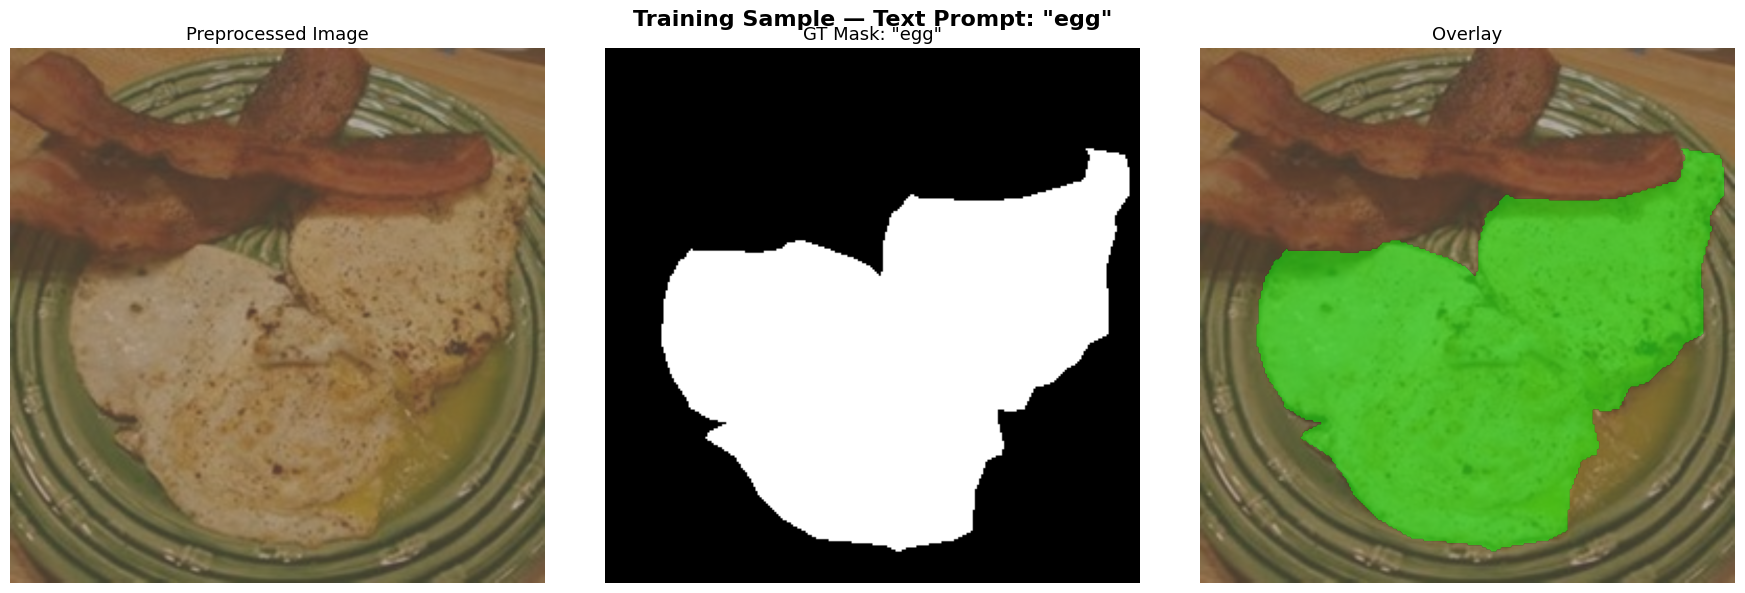

In [10]:
# ============================================================
# Step 5.9: Visualize a training sample
# ============================================================
sample_idx = 0
sample_item = train_dataset[sample_idx]
gt_mask = sample_item['gt_mask'].numpy()
cls_name = sample_item['class_name']

# Decode pixel values back to viewable image (approximate)
pixel_vals = sample_item['pixel_values']
# Undo normalization (approximate — for visualization only)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img_vis = (pixel_vals * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_vis)
axes[0].set_title(f"Preprocessed Image", fontsize=13)
axes[0].axis('off')

axes[1].imshow(gt_mask, cmap='gray')
axes[1].set_title(f'GT Mask: "{cls_name}"', fontsize=13)
axes[1].axis('off')

axes[2].imshow(img_vis)
gt_overlay = np.zeros((*gt_mask.shape, 4))
gt_overlay[gt_mask > 0] = [0, 1, 0, 0.5]
# Resize overlay to match image if needed
if gt_overlay.shape[:2] != img_vis.shape[:2]:
    from PIL import Image
    gt_resized = np.array(Image.fromarray((gt_mask * 255).astype(np.uint8)).resize(
        (img_vis.shape[1], img_vis.shape[0]))) > 128
    gt_overlay = np.zeros((*img_vis.shape[:2], 4))
    gt_overlay[gt_resized] = [0, 1, 0, 0.5]
axes[2].imshow(gt_overlay)
axes[2].set_title("Overlay", fontsize=13)
axes[2].axis('off')

plt.suptitle(f'Training Sample — Text Prompt: "{cls_name}"',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 💡 Key Concept: Loss Function for Segmentation

To train, we need a **loss function** that measures how wrong the predictions are.
For segmentation, we use **two losses** combined:

```
Total Loss = BCE Loss + Dice Loss

BCE (Binary Cross-Entropy):        Dice Loss:
┌────────────────────────┐         ┌────────────────────────┐
│ Measures per-pixel     │         │ Measures overall mask  │
│ classification error   │         │ overlap (like IoU)     │
│                        │         │                        │
│ Good at: pixel details │         │ Good at: shape match   │
│ Bad at: class imbalance│         │ Bad at: small objects   │
└────────────────────────┘         └────────────────────────┘

Combined = Best of both worlds! ✅
```

In [11]:
# ============================================================
# Step 5.10: Define loss functions
# ============================================================

class SegmentationLoss(nn.Module):
    """
    Combined loss for segmentation fine-tuning.

    BCE Loss  — penalizes wrong pixel predictions
    Dice Loss — penalizes poor mask overlap
    """

    def __init__(self, bce_weight=1.0, dice_weight=1.0):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def dice_loss(self, pred, target, smooth=1.0):
        """
        Dice Loss = 1 - (2 * |pred ∩ target|) / (|pred| + |target|)

        Perfect prediction → Dice Loss = 0
        No overlap at all → Dice Loss = 1
        """
        pred_flat = pred.flatten()
        target_flat = target.flatten()
        intersection = (pred_flat * target_flat).sum()
        dice = (2.0 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
        return 1.0 - dice

    def forward(self, pred_masks, gt_masks, iou_scores=None):
        """
        Compute combined loss.

        Args:
            pred_masks: model predictions (logits, before sigmoid)
            gt_masks: list of ground truth binary masks
            iou_scores: predicted IoU scores (optional, for auxiliary loss)

        Returns:
            total_loss, dict of individual losses
        """
        total_bce = 0.0
        total_dice = 0.0
        total_iou_loss = 0.0
        count = 0

        for i, gt_mask in enumerate(gt_masks):
            # Get prediction for this sample
            pred = pred_masks[i]  # Shape: (num_masks, H, W) or similar

            # Take the best mask (highest IoU prediction)
            if pred.dim() == 3:
                if iou_scores is not None:
                    best_idx = iou_scores[i].argmax()
                    pred = pred[best_idx]
                else:
                    pred = pred[0]

            # Resize prediction to match ground truth
            gt_h, gt_w = gt_mask.shape
            if pred.shape != gt_mask.shape:
                pred = F.interpolate(
                    pred.unsqueeze(0).unsqueeze(0).float(),
                    size=(gt_h, gt_w),
                    mode='bilinear',
                    align_corners=False
                ).squeeze(0).squeeze(0)

            gt_mask = gt_mask.to(pred.device).float()

            # BCE loss (on logits — numerically stable)
            bce = F.binary_cross_entropy_with_logits(pred, gt_mask)

            # Dice loss (on probabilities)
            pred_prob = torch.sigmoid(pred)
            dice = self.dice_loss(pred_prob, gt_mask)

            total_bce += bce
            total_dice += dice

            # Optional: IoU prediction loss
            if iou_scores is not None:
                pred_binary = (pred_prob > 0.5).float()
                actual_iou = self._compute_iou(pred_binary, gt_mask)
                iou_pred = iou_scores[i].max()
                total_iou_loss += F.mse_loss(iou_pred, actual_iou)

            count += 1

        # Average over batch
        avg_bce = total_bce / max(count, 1)
        avg_dice = total_dice / max(count, 1)
        avg_iou_loss = total_iou_loss / max(count, 1)

        total_loss = (self.bce_weight * avg_bce +
                      self.dice_weight * avg_dice +
                      0.5 * avg_iou_loss)

        losses = {
            'total': total_loss.item(),
            'bce': avg_bce.item(),
            'dice': avg_dice.item(),
            'iou_loss': avg_iou_loss.item() if isinstance(avg_iou_loss, torch.Tensor) else avg_iou_loss
        }

        return total_loss, losses

    @staticmethod
    def _compute_iou(pred, target):
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        return (intersection / (union + 1e-6)).detach()


criterion = SegmentationLoss(bce_weight=1.0, dice_weight=1.0)
print("✅ Loss function defined: BCE + Dice + IoU auxiliary")

✅ Loss function defined: BCE + Dice + IoU auxiliary


In [12]:
# ============================================================
# Step 5.11: Baseline evaluation (BEFORE fine-tuning)
# ============================================================
# Record performance BEFORE training so we can measure improvement

def evaluate_model(model, processor, dataset, device, num_samples=50):
    """
    Evaluate model on a subset of the dataset.

    Returns:
        dict with per-class and overall IoU scores
    """
    model.eval()
    class_ious = defaultdict(list)

    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    for i, idx in enumerate(indices):
        item = dataset[idx]
        img_idx, cls_name, cls_id = dataset.samples[idx]
        sample = dataset.hf_dataset[img_idx]
        image = sample['image'].convert("RGB")
        label_array = np.array(sample['label'])
        gt_mask = (label_array == cls_id)
        img_w, img_h = image.size

        # Run inference
        inputs = processor(images=image, text=cls_name, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        # Postprocess
        results = processor.post_process_instance_segmentation(
            outputs, threshold=0.3, mask_threshold=0.5,
            target_sizes=inputs.get("original_sizes").tolist()
        )[0]

        # Combine all predicted masks
        pred_mask = np.zeros((img_h, img_w), dtype=bool)
        for m in results.get('masks', []):
            m_np = m.cpu().numpy() if torch.is_tensor(m) else np.array(m)
            pred_mask |= (m_np > 0)

        # Compute IoU
        intersection = np.logical_and(gt_mask, pred_mask).sum()
        union = np.logical_or(gt_mask, pred_mask).sum()
        iou = intersection / union if union > 0 else 0.0

        class_ious[cls_name].append(iou)

        if (i + 1) % 10 == 0:
            print(f"   Evaluated {i+1}/{len(indices)}...")

    # Compute averages
    results = {}
    all_ious = []
    for cls_name, ious in sorted(class_ious.items()):
        mean_iou = np.mean(ious)
        results[cls_name] = {'mean_iou': mean_iou, 'count': len(ious)}
        all_ious.extend(ious)

    results['__overall__'] = {'mean_iou': np.mean(all_ious), 'count': len(all_ious)}
    return results


print("📊 Evaluating BASELINE performance (before fine-tuning)...")
print("   This may take a few minutes...\n")

baseline_results = evaluate_model(model, processor, val_dataset, device, num_samples=50)

print("\n📊 BASELINE Results (Before Fine-tuning):")
print(f"{'Class':>20s} | {'mIoU':>8s} | {'Samples':>7s}")
print("-" * 42)
for cls_name, info in sorted(baseline_results.items()):
    if cls_name == '__overall__':
        continue
    emoji = '🟢' if info['mean_iou'] > 0.5 else '🟡' if info['mean_iou'] > 0.25 else '🔴'
    print(f"{cls_name:>20s} | {info['mean_iou']:>7.4f} {emoji} | {info['count']:>7d}")
print("-" * 42)
overall = baseline_results['__overall__']
print(f"{'OVERALL':>20s} | {overall['mean_iou']:>7.4f}    | {overall['count']:>7d}")

print("\n✅ Lab 5 Complete! Data pipeline and baseline ready.")

📊 Evaluating BASELINE performance (before fine-tuning)...
   This may take a few minutes...

   Evaluated 10/50...
   Evaluated 20/50...
   Evaluated 30/50...
   Evaluated 40/50...
   Evaluated 50/50...

📊 BASELINE Results (Before Fine-tuning):
               Class |     mIoU | Samples
------------------------------------------
               bread |  0.8375 🟢 |      15
        chicken duck |  0.2026 🔴 |      15
             lettuce |  0.0000 🔴 |      14
            mushroom |  0.0000 🔴 |       1
              potato |  0.0000 🔴 |       1
                rice |  0.9115 🟢 |       3
              tomato |  0.0000 🔴 |       1
------------------------------------------
             OVERALL |  0.3667    |      50

✅ Lab 5 Complete! Data pipeline and baseline ready.


---
# 🟢 Lab 6: Fine-tune SAM 3 with LoRA

### 🎯 Learning Objectives
By the end of this lab, you will:
1. Understand **LoRA** (Low-Rank Adaptation) and why it's efficient
2. Apply LoRA to SAM 3's decoder layers
3. Run the **training loop** with proper logging
4. Monitor loss curves during training

### 💡 Key Concept: What is LoRA?

Instead of updating ALL 848M parameters, LoRA adds tiny "adapter" matrices
to specific layers and only trains those.

```
Original weight matrix W (frozen):
┌───────────────────┐
│                   │  768 × 768 = 589,824 params (FROZEN)
│    W (frozen)     │
│                   │
└───────────────────┘

LoRA adapters (trainable):
┌──────┐   ┌──────────────┐
│  A   │ × │      B       │  768 × 8 + 8 × 768 = 12,288 params (TRAINABLE)
│768×8 │   │    8×768     │
└──────┘   └──────────────┘

Output = W·x + A·B·x  (original + small correction)

Reduction: 589,824 → 12,288 = 48× fewer trainable params! 🚀
```

In [13]:
# ============================================================
# Step 6.1: Inspect model architecture to find target layers
# ============================================================
# Before applying LoRA, let's understand the model structure

print("🔍 SAM 3 Model Architecture Overview:")
print("=" * 60)

# Count parameters per major component
component_params = defaultdict(int)
for name, param in model.named_parameters():
    component = name.split('.')[0]  # Top-level module name
    component_params[component] += param.numel()

total = sum(component_params.values())
for comp, count in sorted(component_params.items(), key=lambda x: -x[1]):
    pct = 100.0 * count / total
    bar = '█' * int(pct / 2)
    print(f"   {comp:>30s}: {count:>12,} params ({pct:5.1f}%) {bar}")
print(f"   {'TOTAL':>30s}: {total:>12,} params")

🔍 SAM 3 Model Architecture Overview:
                   vision_encoder:  454,038,784 params ( 54.0%) ███████████████████████████
                     text_encoder:  353,462,272 params ( 42.1%) █████████████████████
                     detr_decoder:   11,575,093 params (  1.4%) 
                     detr_encoder:    9,472,512 params (  1.1%) 
                 geometry_encoder:    8,083,456 params (  1.0%) 
                     mask_decoder:    2,298,881 params (  0.3%) 
              dot_product_scoring:    1,182,976 params (  0.1%) 
                  text_projection:      262,400 params (  0.0%) 
                            TOTAL:  840,376,374 params


In [14]:
# ============================================================
# Step 6.2: Find linear layers suitable for LoRA
# ============================================================
# LoRA works best on linear (fully-connected) layers in attention blocks

print("\n🔍 Linear layers in the model:")
linear_layers = []
for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        linear_layers.append((name, module.in_features, module.out_features))

# Show a sample of layers
print(f"   Found {len(linear_layers)} linear layers total\n")
print(f"   {'Layer Name':<60s} | {'In':>6s} | {'Out':>6s}")
print("   " + "-" * 80)
for name, in_f, out_f in linear_layers[:15]:
    print(f"   {name:<60s} | {in_f:>6d} | {out_f:>6d}")
if len(linear_layers) > 15:
    print(f"   ... and {len(linear_layers) - 15} more layers")


🔍 Linear layers in the model:
   Found 538 linear layers total

   Layer Name                                                   |     In |    Out
   --------------------------------------------------------------------------------
   vision_encoder.backbone.layers.0.attention.q_proj            |   1024 |   1024
   vision_encoder.backbone.layers.0.attention.k_proj            |   1024 |   1024
   vision_encoder.backbone.layers.0.attention.v_proj            |   1024 |   1024
   vision_encoder.backbone.layers.0.attention.o_proj            |   1024 |   1024
   vision_encoder.backbone.layers.0.mlp.fc1                     |   1024 |   4736
   vision_encoder.backbone.layers.0.mlp.fc2                     |   4736 |   1024
   vision_encoder.backbone.layers.1.attention.q_proj            |   1024 |   1024
   vision_encoder.backbone.layers.1.attention.k_proj            |   1024 |   1024
   vision_encoder.backbone.layers.1.attention.v_proj            |   1024 |   1024
   vision_encoder.backbone.laye

In [15]:
# ============================================================
# Step 6.3: Apply LoRA using PEFT library
# ============================================================
from peft import LoraConfig, get_peft_model, TaskType

# Configure LoRA
lora_config = LoraConfig(
    r=6,                    # Rank (lower = fewer params, higher = more capacity)
    lora_alpha=16,          # Scaling factor (typically 2× rank)
    lora_dropout=0.1,       # Dropout for regularization
    target_modules=[        # Which layers to add LoRA to
        "q_proj", "v_proj", # Attention query and value projections
        "k_proj",           # Attention key projection
        "out_proj",         # Attention output projection
    ],
    bias="none",            # Don't train bias terms
    modules_to_save=None,   # Additional modules to fully train (None = LoRA only)
)

print("📋 LoRA Configuration:")
print(f"   Rank (r)       : {lora_config.r}")
print(f"   Alpha          : {lora_config.lora_alpha}")
print(f"   Dropout        : {lora_config.lora_dropout}")
print(f"   Target modules : {lora_config.target_modules}")

📋 LoRA Configuration:
   Rank (r)       : 6
   Alpha          : 16
   Dropout        : 0.1
   Target modules : {'q_proj', 'k_proj', 'out_proj', 'v_proj'}


In [16]:
# ============================================================
# Step 6.4: Wrap model with LoRA adapters
# ============================================================
print("\n⏳ Applying LoRA adapters to SAM 3...")

model_lora = get_peft_model(model, lora_config)

# Count trainable vs frozen parameters
trainable_params = sum(p.numel() for p in model_lora.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_lora.parameters())
frozen_params = total_params - trainable_params

print(f"\n✅ LoRA applied!")
print(f"   Total parameters     : {total_params:>12,}")
print(f"   Trainable (LoRA)     : {trainable_params:>12,} ({100*trainable_params/total_params:.2f}%)")
print(f"   Frozen (original)    : {frozen_params:>12,} ({100*frozen_params/total_params:.2f}%)")
print(f"\n   💡 Training only {trainable_params/1e6:.1f}M out of {total_params/1e6:.1f}M parameters!")

# Show LoRA architecture summary
model_lora.print_trainable_parameters()


⏳ Applying LoRA adapters to SAM 3...

✅ LoRA applied!
   Total parameters     :  843,076,662
   Trainable (LoRA)     :    2,700,288 (0.32%)
   Frozen (original)    :  840,376,374 (99.68%)

   💡 Training only 2.7M out of 843.1M parameters!
trainable params: 2,700,288 || all params: 843,076,662 || trainable%: 0.3203


### 💡 Understanding the LoRA Wrap

```
BEFORE LoRA:                          AFTER LoRA:
┌──────────────────────┐              ┌──────────────────────┐
│ q_proj: Linear(768)  │  trainable   │ q_proj: Linear(768)  │  FROZEN ❄️
│ v_proj: Linear(768)  │  trainable   │   + lora_A (768→8)   │  trainable 🔥
│ k_proj: Linear(768)  │  trainable   │   + lora_B (8→768)   │  trainable 🔥
│ ...848M params total  │              │ v_proj: Linear(768)  │  FROZEN ❄️
└──────────────────────┘              │   + lora_A (768→8)   │  trainable 🔥
                                      │   + lora_B (8→768)   │  trainable 🔥
                                      │ ...~2-5M trainable   │
                                      └──────────────────────┘
```

In [17]:
# ============================================================
# Step 6.5: Setup optimizer and learning rate scheduler
# ============================================================

# Only optimize LoRA parameters (the trainable ones)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_lora.parameters()),
    lr=1e-4,            # Learning rate (start relatively high for LoRA)
    weight_decay=0.01   # L2 regularization
)

# Cosine annealing: gradually decrease learning rate
NUM_EPOCHS = 5
TOTAL_STEPS = NUM_EPOCHS * len(train_loader)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=TOTAL_STEPS,
    eta_min=1e-6  # Minimum learning rate
)

print("✅ Optimizer & Scheduler configured:")
print(f"   Optimizer      : AdamW (lr=1e-4, wd=0.01)")
print(f"   Scheduler      : CosineAnnealing (T_max={TOTAL_STEPS})")
print(f"   Epochs         : {NUM_EPOCHS}")
print(f"   Steps per epoch: {len(train_loader)}")
print(f"   Total steps    : {TOTAL_STEPS}")

✅ Optimizer & Scheduler configured:
   Optimizer      : AdamW (lr=1e-4, wd=0.01)
   Scheduler      : CosineAnnealing (T_max=3000)
   Epochs         : 5
   Steps per epoch: 600
   Total steps    : 3000


### 💡 Key Concept: The Training Loop

Every deep learning training follows this cycle:

```
┌──────────────────────────────────────────────────────┐
│  FOR each epoch:                                      │
│    FOR each batch:                                    │
│                                                       │
│      1. Forward Pass  — predict masks                 │
│         prediction = model(image, text)               │
│                                                       │
│      2. Compute Loss  — how wrong are we?             │
│         loss = criterion(prediction, ground_truth)    │
│                                                       │
│      3. Backward Pass — compute gradients             │
│         loss.backward()                               │
│                                                       │
│      4. Update Weights — adjust LoRA parameters       │
│         optimizer.step()                              │
│                                                       │
│      5. Log & Repeat                                  │
└──────────────────────────────────────────────────────┘
```

In [18]:
# ============================================================
# Step 6.6: Training Loop
# ============================================================

def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device, epoch):
    """Train for one epoch and return metrics."""
    model.train()
    epoch_losses = defaultdict(list)
    start_time = time.time()

    for step, batch in enumerate(train_loader):
        # ── 1. Move inputs to device ──
        inputs = {k: v.to(device) for k, v in batch.items()
                  if isinstance(v, torch.Tensor)}
        gt_masks = [m.to(device) for m in batch['gt_masks']]

        # ── 2. Forward pass ──
        outputs = model(**inputs)

        # ── 3. Compute loss ──
        pred_masks = outputs.pred_masks.squeeze(1)  # Remove extra dims
        iou_scores = outputs.iou_scores.squeeze(1) if hasattr(outputs, 'iou_scores') else None

        loss, loss_dict = criterion(pred_masks, gt_masks, iou_scores)

        # ── 4. Backward pass ──
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(
            filter(lambda p: p.requires_grad, model.parameters()),
            max_norm=1.0
        )

        # ── 5. Update weights ──
        optimizer.step()
        scheduler.step()

        # ── 6. Log ──
        for k, v in loss_dict.items():
            epoch_losses[k].append(v)

        if (step + 1) % 10 == 0 or step == 0:
            elapsed = time.time() - start_time
            lr = optimizer.param_groups[0]['lr']
            print(f"   Epoch {epoch+1} | Step {step+1:>4d}/{len(train_loader)} | "
                  f"Loss: {loss_dict['total']:.4f} | "
                  f"BCE: {loss_dict['bce']:.4f} | "
                  f"Dice: {loss_dict['dice']:.4f} | "
                  f"LR: {lr:.6f} | "
                  f"Time: {elapsed:.0f}s")

    # Compute epoch averages
    avg_losses = {k: np.mean(v) for k, v in epoch_losses.items()}
    return avg_losses


@torch.no_grad()
def validate(model, val_loader, criterion, device):
    """Validate and return metrics."""
    model.eval()
    val_losses = defaultdict(list)
    all_ious = []

    for batch in val_loader:
        inputs = {k: v.to(device) for k, v in batch.items()
                  if isinstance(v, torch.Tensor)}
        gt_masks = [m.to(device) for m in batch['gt_masks']]

        outputs = model(**inputs)
        pred_masks = outputs.pred_masks.squeeze(1)
        iou_scores = outputs.iou_scores.squeeze(1) if hasattr(outputs, 'iou_scores') else None

        loss, loss_dict = criterion(pred_masks, gt_masks, iou_scores)

        for k, v in loss_dict.items():
            val_losses[k].append(v)

        # Compute IoU for monitoring
        for i, gt_mask in enumerate(gt_masks):
            pred = pred_masks[i]
            if pred.dim() == 3:
                pred = pred[0]
            gt_h, gt_w = gt_mask.shape
            if pred.shape != gt_mask.shape:
                pred = F.interpolate(
                    pred.unsqueeze(0).unsqueeze(0).float(),
                    size=(gt_h, gt_w), mode='bilinear', align_corners=False
                ).squeeze()
            pred_binary = (torch.sigmoid(pred) > 0.5).float()
            intersection = (pred_binary * gt_mask).sum()
            union = pred_binary.sum() + gt_mask.sum() - intersection
            iou = (intersection / (union + 1e-6)).item()
            all_ious.append(iou)

    avg_losses = {k: np.mean(v) for k, v in val_losses.items()}
    avg_losses['mean_iou'] = np.mean(all_ious)
    return avg_losses


print("✅ Training and validation functions defined!")

✅ Training and validation functions defined!


In [ ]:
# ============================================================
# Step 6.7: Run Training! 🚀
# ============================================================
print("🚀 Starting Fine-tuning!")
print("=" * 70)

history = {
    'train_loss': [], 'train_bce': [], 'train_dice': [],
    'val_loss': [], 'val_bce': [], 'val_dice': [], 'val_iou': [],
    'lr': []
}

best_val_iou = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*70}")
    print(f"📖 Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*70}")

    # ── Train ──
    train_losses = train_one_epoch(
        model_lora, train_loader, criterion, optimizer, scheduler, device, epoch
    )

    # ── Validate ──
    val_losses = validate(model_lora, val_loader, criterion, device)

    # ── Log ──
    history['train_loss'].append(train_losses['total'])
    history['train_bce'].append(train_losses['bce'])
    history['train_dice'].append(train_losses['dice'])
    history['val_loss'].append(val_losses['total'])
    history['val_bce'].append(val_losses['bce'])
    history['val_dice'].append(val_losses['dice'])
    history['val_iou'].append(val_losses['mean_iou'])
    history['lr'].append(optimizer.param_groups[0]['lr'])

    # ── Summary ──
    print(f"\n   📊 Epoch {epoch+1} Summary:")
    print(f"      Train Loss: {train_losses['total']:.4f} (BCE: {train_losses['bce']:.4f}, Dice: {train_losses['dice']:.4f})")
    print(f"      Val Loss  : {val_losses['total']:.4f} (BCE: {val_losses['bce']:.4f}, Dice: {val_losses['dice']:.4f})")
    print(f"      Val mIoU  : {val_losses['mean_iou']:.4f}", end='')

    # Save best model
    if val_losses['mean_iou'] > best_val_iou:
        best_val_iou = val_losses['mean_iou']
        # Save LoRA weights only (very small file!)
        model_lora.save_pretrained("sam3_lora_best")
        print(f"  ← 🏆 New best! Saved to sam3_lora_best/")
    else:
        print()

print(f"\n{'='*70}")
print(f"✅ Training Complete!")
print(f"   Best Val mIoU: {best_val_iou:.4f}")
print(f"{'='*70}")

🚀 Starting Fine-tuning!

📖 Epoch 1/5
   Epoch 1 | Step    1/600 | Loss: 4.7916 | BCE: 3.7916 | Dice: 1.0000 | LR: 0.000100 | Time: 1s
   Epoch 1 | Step   10/600 | Loss: 5.9317 | BCE: 4.9850 | Dice: 0.9467 | LR: 0.000100 | Time: 9s
   Epoch 1 | Step   20/600 | Loss: 2.1818 | BCE: 1.1831 | Dice: 0.9987 | LR: 0.000100 | Time: 18s
   Epoch 1 | Step   30/600 | Loss: 2.3573 | BCE: 1.3620 | Dice: 0.9953 | LR: 0.000100 | Time: 27s
   Epoch 1 | Step   40/600 | Loss: 1.7293 | BCE: 0.7382 | Dice: 0.9911 | LR: 0.000100 | Time: 36s
   Epoch 1 | Step   50/600 | Loss: 1.2521 | BCE: 0.4667 | Dice: 0.7854 | LR: 0.000100 | Time: 44s
   Epoch 1 | Step   60/600 | Loss: 1.1030 | BCE: 0.3010 | Dice: 0.8020 | LR: 0.000100 | Time: 53s
   Epoch 1 | Step   70/600 | Loss: 0.8305 | BCE: 0.3025 | Dice: 0.5280 | LR: 0.000100 | Time: 62s
   Epoch 1 | Step   80/600 | Loss: 0.8564 | BCE: 0.3251 | Dice: 0.5312 | LR: 0.000100 | Time: 70s
   Epoch 1 | Step   90/600 | Loss: 0.8182 | BCE: 0.2517 | Dice: 0.5665 | LR: 0.0001

In [ ]:
# ============================================================
# Step 6.8: Plot training curves
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs_range = range(1, NUM_EPOCHS + 1)

# Plot 1: Total Loss
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-o', label='Train', linewidth=2)
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-s', label='Val', linewidth=2)
axes[0, 0].set_title('Total Loss', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: BCE Loss
axes[0, 1].plot(epochs_range, history['train_bce'], 'b-o', label='Train BCE', linewidth=2)
axes[0, 1].plot(epochs_range, history['val_bce'], 'r-s', label='Val BCE', linewidth=2)
axes[0, 1].set_title('BCE Loss', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Dice Loss
axes[1, 0].plot(epochs_range, history['train_dice'], 'b-o', label='Train Dice', linewidth=2)
axes[1, 0].plot(epochs_range, history['val_dice'], 'r-s', label='Val Dice', linewidth=2)
axes[1, 0].set_title('Dice Loss', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Validation IoU
axes[1, 1].plot(epochs_range, history['val_iou'], 'g-D', label='Val mIoU', linewidth=2, markersize=8)
axes[1, 1].axhline(y=baseline_results['__overall__']['mean_iou'], color='orange',
                    linestyle='--', label=f"Baseline ({baseline_results['__overall__']['mean_iou']:.3f})")
axes[1, 1].set_title('Validation mIoU', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('mIoU')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('🔥 SAM 3 LoRA Fine-tuning — Training Curves', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Lab 6 Complete! Model fine-tuned with LoRA.")

---
# 🟢 Lab 7: Evaluation & Comparison

### 🎯 Learning Objectives
By the end of this lab, you will:
1. Evaluate the fine-tuned model on the validation set
2. Compare **before vs after** fine-tuning per class
3. Visualize prediction improvements qualitatively
4. Save and load LoRA weights

In [ ]:
# ============================================================
# Step 7.1: Evaluate fine-tuned model
# ============================================================
print("📊 Evaluating FINE-TUNED model...")

finetuned_results = evaluate_model(model_lora, processor, val_dataset, device, num_samples=400)

print("\n📊 FINE-TUNED Results:")
print(f"{'Class':>20s} | {'Baseline':>8s} | {'FineTuned':>9s} | {'Change':>8s}")
print("-" * 55)

improvements = []
for cls_name in sorted(set(list(baseline_results.keys()) + list(finetuned_results.keys()))):
    # if cls_name == '__overall__':
    #     continue
    base = baseline_results.get(cls_name, {}).get('mean_iou', 0)
    fine = finetuned_results.get(cls_name, {}).get('mean_iou', 0)
    change = fine - base
    improvements.append(change)

    arrow = '📈' if change > 0.02 else '📉' if change < -0.02 else '➡️'
    print(f"{cls_name:>20s} | {base:>7.4f}  | {fine:>8.4f}  | {change:>+7.4f} {arrow}")

print("-" * 55)
base_overall = baseline_results['__overall__']['mean_iou']
fine_overall = finetuned_results['__overall__']['mean_iou']
change = fine_overall - base_overall
print(f"{'OVERALL':>20s} | {base_overall:>7.4f}  | {fine_overall:>8.4f}  | {change:>+7.4f} {'📈' if change > 0 else '📉'}")

In [ ]:
# ============================================================
# Step 7.2: Bar chart comparison
# ============================================================
classes = [k for k in baseline_results.keys() if k != '__overall__']
base_ious = [baseline_results[c]['mean_iou'] for c in classes]
fine_ious = [finetuned_results.get(c, {}).get('mean_iou', 0) for c in classes]

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, base_ious, width, label='Baseline', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x + width/2, fine_ious, width, label='Fine-tuned (LoRA)', color='#4ECDC4', alpha=0.8)

ax.set_xlabel('Food Class', fontsize=12)
ax.set_ylabel('Mean IoU', fontsize=12)
ax.set_title('🏆 SAM 3: Baseline vs Fine-tuned (LoRA) — Per-Class IoU', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# Add value labels on bars
for bar in bars1:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f'{h:.2f}',
            ha='center', va='bottom', fontsize=8)
for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f'{h:.2f}',
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Step 7.3: Qualitative comparison — side-by-side predictions
# ============================================================

def compare_predictions(image, gt_mask, cls_name, model_base, model_fine, processor, device):
    """Show baseline vs fine-tuned predictions side by side."""
    img_w, img_h = image.size
    img_array = np.array(image)

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # Panel 1: Original + GT
    axes[0].imshow(image)
    gt_ov = np.zeros((img_h, img_w, 4))
    gt_ov[gt_mask] = [0, 1, 0, 0.45]
    axes[0].imshow(gt_ov)
    axes[0].set_title(f'Ground Truth: "{cls_name}"', fontsize=12, color='green')
    axes[0].axis('off')

    # Run both models
    for col, (mdl, label, color) in enumerate([
        (model_base, 'Baseline', 'red'),
        (model_fine, 'Fine-tuned (LoRA)', 'blue')
    ], start=1):
        inputs = processor(images=image, text=cls_name, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = mdl(**inputs)

        results = processor.post_process_instance_segmentation(
            outputs, threshold=0.3, mask_threshold=0.5,
            target_sizes=inputs.get("original_sizes").tolist()
        )[0]

        pred_mask = np.zeros((img_h, img_w), dtype=bool)
        for m in results.get('masks', []):
            m_np = m.cpu().numpy() if torch.is_tensor(m) else np.array(m)
            pred_mask |= (m_np > 0)

        # Compute IoU
        intersection = np.logical_and(gt_mask, pred_mask).sum()
        union = np.logical_or(gt_mask, pred_mask).sum()
        iou = intersection / union if union > 0 else 0.0

        axes[col].imshow(image)
        pred_ov = np.zeros((img_h, img_w, 4))
        c = [1, 0, 0] if color == 'red' else [0, 0.4, 1]
        pred_ov[pred_mask] = [*c, 0.45]
        axes[col].imshow(pred_ov)
        axes[col].set_title(f'{label}\nIoU: {iou:.4f}', fontsize=12, color=color)
        axes[col].axis('off')

    # Panel 4: Improvement map
    axes[3].imshow(image)
    # (This is a simplified diff visualization)
    axes[3].set_title('Comparison', fontsize=12)
    axes[3].axis('off')

    plt.suptitle(f'Baseline vs Fine-tuned — "{cls_name}"', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Show a few comparison examples
print("🔍 Qualitative Comparison: Baseline vs Fine-tuned\n")

# Load base model for comparison (without LoRA)
model_base = Sam3Model.from_pretrained("facebook/sam3").to(device)
model_base.eval()

num_comparisons = 8
random_indices = random.sample(range(len(val_dataset)), min(num_comparisons, len(val_dataset)))

for idx in random_indices:
    img_idx, cls_name, cls_id = val_dataset.samples[idx]
    sample = val_dataset.hf_dataset[img_idx]
    image = sample['image'].convert("RGB")
    label_array = np.array(sample['label'])
    gt_mask = (label_array == cls_id)

    compare_predictions(image, gt_mask, cls_name, model_base, model_lora, processor, device)

In [ ]:
# ============================================================
# Step 7.4: Save and load LoRA weights
# ============================================================
# LoRA weights are tiny — usually < 50 MB!

import os

SAVE_DIR = "sam3_lora_foodseg"

# Save LoRA weights
model_lora.save_pretrained(SAVE_DIR)
print(f"✅ LoRA weights saved to '{SAVE_DIR}/'")

# Show file sizes
total_size = 0
for f in os.listdir(SAVE_DIR):
    fpath = os.path.join(SAVE_DIR, f)
    size = os.path.getsize(fpath)
    total_size += size
    print(f"   {f}: {size / 1024:.1f} KB")
print(f"   Total: {total_size / 1024 / 1024:.1f} MB")
print(f"\n   💡 Compare: Full SAM 3 = ~3.4 GB, LoRA weights = ~{total_size/1024/1024:.0f} MB")

### 💡 How to Load LoRA Weights Later

```python
from peft import PeftModel
from transformers import Sam3Model

# Load base model
base_model = Sam3Model.from_pretrained("facebook/sam3")

# Load LoRA adapters on top
model = PeftModel.from_pretrained(base_model, "sam3_lora_foodseg")
model.eval()

# Use it exactly like before!
outputs = model(**inputs)
```

In [ ]:
print("\n✅ Lab 7 Complete! You've evaluated and compared the fine-tuned model.")

---
# 🟢 Lab 8: Advanced Techniques

### 🎯 Learning Objectives
By the end of this lab, you will:
1. Apply **data augmentation** to improve generalization
2. Use **learning rate warmup** for stable training
3. Train with **mixed prompt types** (text + point prompts)
4. Understand **when and how much** to fine-tune

In [ ]:
# ============================================================
# Step 8.1: Data Augmentation for Segmentation
# ============================================================

import torchvision.transforms.v2 as T_v2
import torchvision.transforms.functional as TF


class AugmentedFoodSegDataset(Dataset):
    """
    Enhanced dataset with data augmentation.

    ⚠️ Important: When augmenting segmentation data, we must apply
    the SAME spatial transforms to BOTH the image AND the mask!

    Augmentations used:
    - Random horizontal flip
    - Random rotation (±15°)
    - Color jitter (brightness, contrast, saturation)
    - Random crop + resize
    """

    def __init__(self, hf_dataset, processor, target_classes, max_samples=500,
                 augment=True, crop_size=(512, 512)):
        self.processor = processor
        self.augment = augment
        self.crop_size = crop_size
        self.samples = []

        # Build sample list (same as before)
        for idx in range(len(hf_dataset)):
            sample = hf_dataset[idx]
            for cls_name in target_classes:
                cls_id = LABEL_TO_ID.get(cls_name)
                if cls_id is not None and cls_id in sample['classes_on_image']:
                    self.samples.append((idx, cls_name, cls_id))
            if len(self.samples) >= max_samples:
                break

        random.shuffle(self.samples)
        self.samples = self.samples[:max_samples]
        self.hf_dataset = hf_dataset

        # Color augmentation (applied to image ONLY)
        self.color_jitter = T_v2.ColorJitter(
            brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1
        )

        print(f"✅ Augmented dataset: {len(self.samples)} samples (augment={augment})")

    def __len__(self):
        return len(self.samples)

    def _apply_spatial_transforms(self, image, mask):
        """Apply the same spatial transforms to both image and mask."""

        # Random horizontal flip (50% chance)
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random rotation (±15 degrees)
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            image = TF.rotate(image, angle, fill=0)
            mask = TF.rotate(mask, angle, fill=0)

        # Random resized crop
        if random.random() > 0.5:
            i, j, h, w = T_v2.RandomResizedCrop.get_params(
                image, scale=(0.7, 1.0), ratio=(0.9, 1.1)
            )
            image = TF.resized_crop(image, i, j, h, w, self.crop_size)
            mask = TF.resized_crop(mask, i, j, h, w, self.crop_size,
                                   interpolation=TF.InterpolationMode.NEAREST)

        return image, mask

    def __getitem__(self, idx):
        img_idx, cls_name, cls_id = self.samples[idx]
        sample = self.hf_dataset[img_idx]

        image = sample['image'].convert("RGB")
        label_array = np.array(sample['label'])
        gt_mask = (label_array == cls_id).astype(np.uint8)
        mask_pil = PILImage.fromarray(gt_mask * 255)

        # Apply augmentation
        if self.augment:
            image, mask_pil = self._apply_spatial_transforms(image, mask_pil)
            image = self.color_jitter(image)

        gt_mask = (np.array(mask_pil) > 128).astype(np.float32)

        # Preprocess
        inputs = self.processor(images=image, text=cls_name, return_tensors="pt")
        processed = {k: v.squeeze(0) for k, v in inputs.items()}
        processed['gt_mask'] = torch.from_numpy(gt_mask)
        processed['class_name'] = cls_name
        processed['image_size'] = image.size

        return processed

In [ ]:
# ============================================================
# Step 8.2: Visualize augmentations
# ============================================================

# Create augmented dataset
aug_dataset = AugmentedFoodSegDataset(
    ds, processor, TRAIN_CLASSES, max_samples=200, augment=True
)

# Show same sample with different augmentations
sample_idx = 0
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for col in range(4):
    item = aug_dataset[sample_idx]

    # Decode pixel values for visualization
    pixel_vals = item['pixel_values']
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_vis = (pixel_vals * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()
    gt_mask = item['gt_mask'].numpy()

    axes[0, col].imshow(img_vis)
    axes[0, col].set_title(f'Augmentation #{col+1}', fontsize=11)
    axes[0, col].axis('off')

    axes[1, col].imshow(gt_mask, cmap='gray')
    axes[1, col].set_title(f'Mask #{col+1}', fontsize=11)
    axes[1, col].axis('off')

plt.suptitle(f'Data Augmentation — Same Image, 4 Random Augmentations\n'
             f'Class: "{aug_dataset.samples[sample_idx][1]}"',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 Notice: Each augmentation creates a unique view of the same sample!")
print("   This helps the model learn to be robust to variations.")

In [ ]:
# ============================================================
# Step 8.3: Learning Rate Warmup
# ============================================================

def get_warmup_cosine_scheduler(optimizer, warmup_steps, total_steps):
    """
    Warmup + Cosine Annealing scheduler.

    Learning rate pattern:
    ┌──────────────────────────────────────┐
    │     /‾‾‾‾‾‾‾‾‾‾‾‾\                │
    │    /                 \               │
    │   / warmup   cosine   \              │
    │  /                      \            │
    │ /                        \___        │
    └──────────────────────────────────────┘
      0    warmup_steps    total_steps
    """
    def lr_lambda(step):
        if step < warmup_steps:
            # Linear warmup: 0 → 1
            return step / max(warmup_steps, 1)
        else:
            # Cosine decay: 1 → 0
            progress = (step - warmup_steps) / max(total_steps - warmup_steps, 1)
            return 0.5 * (1 + np.cos(np.pi * progress))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


# Visualize the schedule
steps = list(range(200))
dummy_opt = torch.optim.SGD([torch.zeros(1, requires_grad=True)], lr=1e-4)
dummy_sched = get_warmup_cosine_scheduler(dummy_opt, warmup_steps=20, total_steps=200)

lrs = []
for _ in steps:
    lrs.append(dummy_opt.param_groups[0]['lr'])
    dummy_opt.step()
    dummy_sched.step()

plt.figure(figsize=(10, 4))
plt.plot(steps, lrs, 'b-', linewidth=2)
plt.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='Warmup ends')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Warmup + Cosine Annealing Schedule', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Warmup prevents early training instability by starting with tiny learning rates.")

### 💡 Key Concept: Mixed Prompt Training

In production, users will interact with SAM 3 using **different prompt types**.
Training with multiple prompt types makes the model robust:

```
Training Mix:
┌─────────────────────────────────┐
│  50% Text prompts  ("egg")     │
│  30% Point prompts (⭐ clicks) │
│  20% Box prompts   (📦 boxes)  │
└─────────────────────────────────┘
```

In [ ]:
# ============================================================
# Step 8.4: Mixed prompt training dataset
# ============================================================

class MixedPromptDataset(Dataset):
    """
    Dataset that randomly picks prompt types for each sample.

    This trains the model to respond well to ALL prompt types,
    not just text prompts.
    """

    def __init__(self, hf_dataset, text_processor, tracker_processor,
                 target_classes, max_samples=500,
                 text_ratio=0.5, point_ratio=0.3, box_ratio=0.2):
        self.text_processor = text_processor
        self.tracker_processor = tracker_processor
        self.text_ratio = text_ratio
        self.point_ratio = point_ratio
        self.box_ratio = box_ratio

        # Build sample list
        self.samples = []
        for idx in range(len(hf_dataset)):
            sample = hf_dataset[idx]
            for cls_name in target_classes:
                cls_id = LABEL_TO_ID.get(cls_name)
                if cls_id is not None and cls_id in sample['classes_on_image']:
                    self.samples.append((idx, cls_name, cls_id))
            if len(self.samples) >= max_samples:
                break

        random.shuffle(self.samples)
        self.samples = self.samples[:max_samples]
        self.hf_dataset = hf_dataset

        print(f"✅ Mixed prompt dataset: {len(self.samples)} samples")
        print(f"   Text: {text_ratio*100:.0f}% | Point: {point_ratio*100:.0f}% | Box: {box_ratio*100:.0f}%")

    def __len__(self):
        return len(self.samples)

    def _get_random_point_on_mask(self, mask):
        """Pick a random point that lies on the mask."""
        ys, xs = np.where(mask > 0)
        if len(ys) == 0:
            return None
        idx = random.randint(0, len(ys) - 1)
        return [int(xs[idx]), int(ys[idx])]

    def _get_bounding_box(self, mask, padding=10):
        """Get bounding box around the mask with optional padding."""
        ys, xs = np.where(mask > 0)
        if len(ys) == 0:
            return None
        x1 = max(0, int(xs.min()) - padding)
        y1 = max(0, int(ys.min()) - padding)
        x2 = min(mask.shape[1], int(xs.max()) + padding)
        y2 = min(mask.shape[0], int(ys.max()) + padding)
        return [x1, y1, x2, y2]

    def __getitem__(self, idx):
        img_idx, cls_name, cls_id = self.samples[idx]
        sample = self.hf_dataset[img_idx]

        image = sample['image'].convert("RGB")
        label_array = np.array(sample['label'])
        gt_mask = (label_array == cls_id).astype(np.float32)

        # Randomly choose prompt type
        rand = random.random()

        if rand < self.text_ratio:
            # TEXT PROMPT
            prompt_type = 'text'
            inputs = self.text_processor(images=image, text=cls_name, return_tensors="pt")

        elif rand < self.text_ratio + self.point_ratio:
            # POINT PROMPT
            prompt_type = 'point'
            point = self._get_random_point_on_mask(gt_mask)
            if point is None:
                # Fallback to text if no mask pixels
                inputs = self.text_processor(images=image, text=cls_name, return_tensors="pt")
                prompt_type = 'text'
            else:
                input_points = [[[[point[0], point[1]]]]]
                input_labels = [[[1]]]
                inputs = self.tracker_processor(
                    images=image, input_points=input_points,
                    input_labels=input_labels, return_tensors="pt"
                )

        else:
            # BOX PROMPT
            prompt_type = 'box'
            box = self._get_bounding_box(gt_mask)
            if box is None:
                inputs = self.text_processor(images=image, text=cls_name, return_tensors="pt")
                prompt_type = 'text'
            else:
                input_boxes = [[[box[0], box[1], box[2], box[3]]]]
                inputs = self.tracker_processor(
                    images=image, input_boxes=input_boxes, return_tensors="pt"
                )

        processed = {k: v.squeeze(0) for k, v in inputs.items()}
        processed['gt_mask'] = torch.from_numpy(gt_mask)
        processed['prompt_type'] = prompt_type
        processed['class_name'] = cls_name

        return processed


# ── Import tracker processor ──
from transformers import Sam3TrackerProcessor
tracker_processor = Sam3TrackerProcessor.from_pretrained("facebook/sam3")

mixed_dataset = MixedPromptDataset(
    ds, processor, tracker_processor, TRAIN_CLASSES, max_samples=300
)

# Count prompt type distribution
prompt_counts = defaultdict(int)
for i in range(min(100, len(mixed_dataset))):
    item = mixed_dataset[i]
    prompt_counts[item['prompt_type']] += 1

print("\n📊 Prompt type distribution (first 100 samples):")
for ptype, count in sorted(prompt_counts.items()):
    print(f"   {ptype:>6s}: {count} samples ({'█' * count})")

---
## 📝 Training Best Practices Summary

| Setting | Recommended Value | Why |
|---------|------------------|-----|
| **LoRA rank (r)** | 4–16 | 8 is good default; higher for complex domains |
| **Learning rate** | 1e-4 to 5e-4 | Higher than full fine-tuning (fewer params) |
| **Batch size** | 2–8 | Limited by GPU VRAM |
| **Epochs** | 3–10 | Watch for overfitting via val loss |
| **Warmup** | 5–10% of steps | Prevents early instability |
| **Augmentation** | Always on | Prevents overfitting on small datasets |
| **Weight decay** | 0.01 | Light regularization |
| **Gradient clip** | 1.0 | Prevents exploding gradients |

In [ ]:
# ============================================================
# Step 8.5: Training checklist and next steps
# ============================================================
print("""
╔══════════════════════════════════════════════════════════════╗
║               🎓 SAM 3 Training Lab Complete!                ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  ✅ Lab 5: Built custom Dataset + DataLoader                 ║
║  ✅ Lab 6: Applied LoRA and ran training loop                ║
║  ✅ Lab 7: Evaluated and compared before/after               ║
║  ✅ Lab 8: Augmentation, warmup, mixed prompts               ║
║                                                              ║
╠══════════════════════════════════════════════════════════════╣
║  🚀 Next Steps to Try:                                       ║
║                                                              ║
║  1. Increase training samples (max_samples=2000+)            ║
║  2. Try different LoRA ranks (r=4, r=16, r=32)              ║
║  3. Train on domain-specific data (your own images!)         ║
║  4. Experiment with freezing different model components      ║
║  5. Add more augmentation types (Gaussian blur, cutout)      ║
║  6. Try full fine-tuning if you have a large GPU             ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
""")

---
# 🎓 Full Lab Summary (Basic + Training)

| Lab | Topic | Key Skills |
|-----|-------|------------|
| **1** | Setup & Exploration | Load SAM 3, explore FoodSeg103 dataset |
| **2** | Text Prompts | `"egg"` → find all eggs, measure IoU |
| **3** | Point Clicks | Click to segment, positive/negative points |
| **4** | Box + Combined | Bounding boxes, multi-prompt precision |
| **5** | Training Foundations | Custom Dataset, DataLoader, loss functions |
| **6** | LoRA Fine-tuning | Apply LoRA, training loop, loss curves |
| **7** | Evaluation | Before/after comparison, save/load weights |
| **8** | Advanced Training | Augmentation, warmup, mixed prompts |

## 🧪 Decision Guide: When to Fine-tune?

```
Is SAM 3 good enough for your task?
  ├── YES → Use it as-is! (Labs 1-4)
  └── NO → Fine-tune!
      ├── Small dataset (<1000 images)?
      │   └── Use LoRA (r=8) + heavy augmentation (Lab 6+8)
      ├── Medium dataset (1K-10K)?
      │   └── Use LoRA (r=16) or freeze encoder (Lab 6)
      └── Large dataset (10K+)?
          └── Full fine-tune with gradual unfreezing
```